# **Desafio de Redes Neurais - Gabriel Dantas de Moraes Almeida**

Repositório Git desse desafio: [link](https://github.com/gdantas04/Desafios-Trainee-IEEE-CIS/tree/main/semana03).

### Bibliotecas utilizadas

In [1]:
import os
import kagglehub

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

from itertools import product

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

2025-06-01 11:21:52.492683: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 11:21:52.522454: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.




---



## **Tarefa 01:** Apenas com a observação dos dados por meio de tabelas e dataframe, apresente suas hipóteses

 ### Importação do banco de dados

In [2]:
databaseFolder = kagglehub.dataset_download("fedesoriano/stellar-classification-dataset-sdss17")
csvPath = os.path.join(databaseFolder, 'star_classification.csv')

In [3]:
df = pd.read_csv(csvPath)
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


 ### Análise exploratória de dados e tratamento do banco de dados

Podemos iniciar a análise verificando por linhas duplicadas

In [4]:
df[df.duplicated()]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID


Agora vamos remover as colunas que não agregarão para o aprendizado do modelo de rede neural:

In [5]:
df = df.drop(['obj_ID', 'spec_obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'plate', 'MJD', 'fiber_ID'], axis=1)
df.head()

,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123


Podemos analisar quais os tipos de variáveis o Dataset possui:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha     100000 non-null  float64
 1   delta     100000 non-null  float64
 2   u         100000 non-null  float64
 3   g         100000 non-null  float64
 4   r         100000 non-null  float64
 5   i         100000 non-null  float64
 6   z         100000 non-null  float64
 7   class     100000 non-null  object 
 8   redshift  100000 non-null  float64
dtypes: float64(8), object(1)
memory usage: 6.9+ MB


Evidentemente todas as variáveis exceto o ```class``` são numéricas, iremos convertê-lo para numérico futuramente.

Adicionalmente, vamos verificar se existem valores faltantes no Dataset. Neste caso, nenhuma variável pode possuir 0 como uma representação de um valor faltante. Por isso, basta fazer a seguinte análise:

In [7]:
df.isnull().sum()

alpha       0
delta       0
u           0
g           0
r           0
i           0
z           0
class       0
redshift    0
dtype: int64

Como visto, não existem valores faltantes.

Agora vamos verificar e remover os outliers no banco de dados por meio do código abaixo:

In [8]:
def remove_outliers(df):
    df_clean = df.copy()

    for column in df_clean.columns:
        if df_clean[column].dtype in ['float64', 'int64']:
            mean = df_clean[column].mean()
            std = df_clean[column].std()
            is_outlier = abs(df_clean[column] - mean) > 3 * std

            num_outliers = is_outlier.sum()
            print(f"Outliers encontrados na coluna '{column}': {num_outliers}")

            df_clean = df_clean[~is_outlier]

    print(f"\nTamanho original: {len(df)}")
    print(f"Tamanho após remoção de outliers: {len(df_clean)}")
    print(f"Integridade: {len(df_clean)/len(df) * 100 :.2f}%")
    return df_clean

df = remove_outliers(df)

Outliers encontrados na coluna 'alpha': 0
Outliers encontrados na coluna 'delta': 0
Outliers encontrados na coluna 'u': 1
Outliers encontrados na coluna 'g': 150
Outliers encontrados na coluna 'r': 84
Outliers encontrados na coluna 'i': 101
Outliers encontrados na coluna 'z': 20
Outliers encontrados na coluna 'redshift': 1830

Tamanho original: 100000
Tamanho após remoção de outliers: 97814
Integridade: 97.81%


Como podemos ver, a remoção de outliers manteve boa parte do banco de dados.

Vamos analisar se o dataset é desbalanceado:

In [9]:
df['class'].value_counts()

class
GALAXY    59204
STAR      21505
QSO       17105
Name: count, dtype: int64

Evidentemente há um desabalanceamento entre os resultados da coluna ```class```. Será fundamental treinar o modelo de rede neural considerando isso.


Ademais, para que o modelo de rede neural possa compreender corretamente o dataset, vamos padronizar todas as colunas exceto o ```class```, o qual receberá um encoding.

In [10]:
scaler = StandardScaler()

columns_to_scale = df.drop('class', axis=1).columns
df_sc = scaler.fit_transform(df[ df.drop('class', axis=1).columns])
df_sc = pd.DataFrame(df_sc, columns=columns_to_scale, index=df.index)
df_sc['class'] = df['class']

In [11]:
encoder = LabelEncoder()
df_sc['class'] = encoder.fit_transform(df_sc['class'])

df_sc.head()

,alpha,delta,u,g,r,i,z,redshift,class
0,-0.434148,0.424526,0.806834,0.812741,0.413639,0.058075,0.026503,0.189570,0
1,-0.339498,0.362431,1.208103,1.087759,1.606861,1.216404,1.650310,0.432083,0
2,-0.366818,0.581630,1.424853,1.004751,0.530676,0.163843,0.115483,0.205364,0
3,1.669253,-1.249260,0.029092,1.554544,1.076682,0.832541,0.289248,0.689494,0
4,1.737017,-0.150954,-1.176202,-1.507163,-1.710490,-1.786457,-1.844017,-0.681862,0


Adicionalmente, vamos compreender como cada variável se correlaciona com o alvo:

In [12]:
def Correlations(dataframe, variableToCompare):
    correlations = []

    # Calcula a correlação entre cada coluna e a variável de interesse
    for column in dataframe.columns:
        if column != variableToCompare:
            correlation = dataframe[[column, variableToCompare]].corr().loc[variableToCompare, column]
            correlations.append((column, correlation))

    # Ordena os resultados da maior para a menor correlação
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)

    for col, corr in correlations:
        print(f'{col}: {corr:.3f}')

In [13]:
Correlations(df_sc, 'class')

u: -0.284
g: -0.239
redshift: -0.112
r: -0.086
z: 0.059
delta: 0.015
alpha: -0.012
i: 0.005


 ### Implementação da rede neural

Podemos definir uma função para utilizar a rede neural com mais facilidade. A partir dessa função, poderemos analisar como a variação de diferentes parâmetros alteram a performance da rede neural:
A função neural_network constrói, compila e treina uma rede neural em Keras com várias opções configuráveis:

1) Divide os dados em treino e teste.

2) Calcula pesos para lidar com classes desbalanceadas.

3) Configura regularização (L1, L2 ou nenhuma).

4) Escolhe o otimizador (adam, sgd, rmsprop ou adagrad).

5) Constrói uma rede com depth camadas densas com length neurônios, opcionalmente com dropout.

6) Adiciona uma camada de saída com 3 classes e ativação softmax.

7) Compila e treina o modelo com os dados fornecidos.

In [14]:
def neural_network(X, y, length, depth, learning_rate, epochs, regularization=None, dropout=None, optimizer_name='adam'):
    
    # Divisão em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Tratamento dos dados desbalanceados
    weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {i: w for i, w in enumerate(weights)}

    # Regularizadores
    if regularization == 'l2':
        reg = regularizers.l2(0.001)
    elif regularization == 'l1':
        reg = regularizers.l1(0.001)
    else:
        reg = None

    # Otimizadores
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)

    # Modelo
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))
    
    for _ in range(depth):
        model.add(Dense(length, activation='relu', kernel_regularizer=reg))
        if dropout:
            model.add(Dropout(dropout))

    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Treinamento com early stopping
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32,
                        validation_data=(X_test, y_test),
                        class_weight=class_weights,
                        callbacks=[early_stop],
                        verbose=0)

    return model, history

 ### Análise dos parâmetros da rede neural

Vamos iniciar fazendo a divisão entre a variável alvo e as features que estamos usando:

In [15]:
X = df_sc.drop('class', axis=1)
y = df_sc['class']

 #### Estudo da variação da profundidade e da largura

Acredita-se que uma boa maneira de visualizar como a profundidade e a largura se combinam para gerar o melhor resultado seja através de um heatmap.
Para isso, vamos fixar o ```learning_rate``` e o número de épocas e ver como o ```val_accuracy``` e o ```val_loss``` se comportam ao variar a largura e a profundidade.

Dessa forma, podemos implementar o código abaixo, que usa uma lógica semelhante ao grid search:

In [16]:
length_values = [64, 128, 256]
depth_values = [8, 10, 12]

accuracy_matrix = np.zeros((len(depth_values), len(length_values)))
val_loss_matrix = np.zeros((len(depth_values), len(length_values)))

for i, d in enumerate(depth_values):
    for j, l in enumerate(length_values):
        model, history = neural_network(X, y, length=l, depth=d, learning_rate=0.001, epochs=3)
        best_epoch = np.argmin(history.history['val_loss'])
        accuracy_matrix[i, j] = history.history['val_accuracy'][best_epoch]
        val_loss_matrix[i, j] = history.history['val_loss'][best_epoch]

Para exibir o heatmap, podemos implementar a seguinte função:

In [17]:
def heatmap(matrix, labelx, labely, title, x_labels, y_labels, cmap='viridis'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt=".4f", xticklabels=x_labels, yticklabels=y_labels, cmap=cmap)
    plt.title(title)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.tight_layout()
    plt.show()

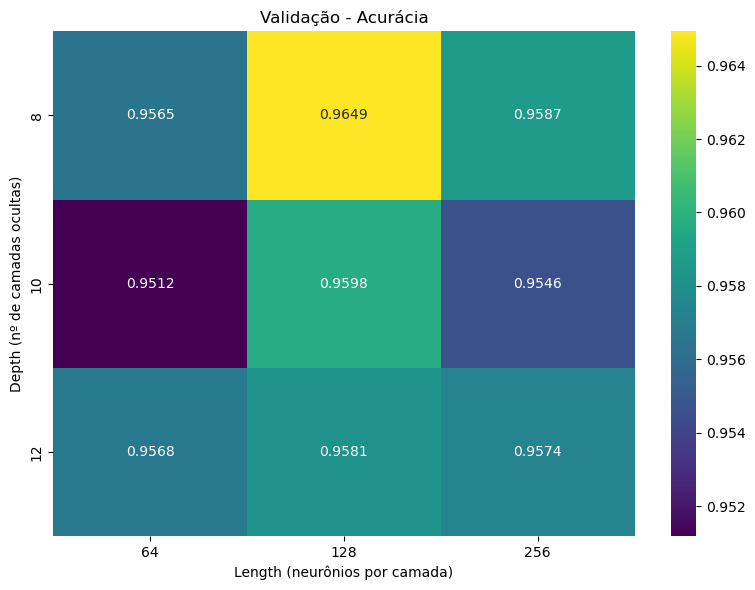

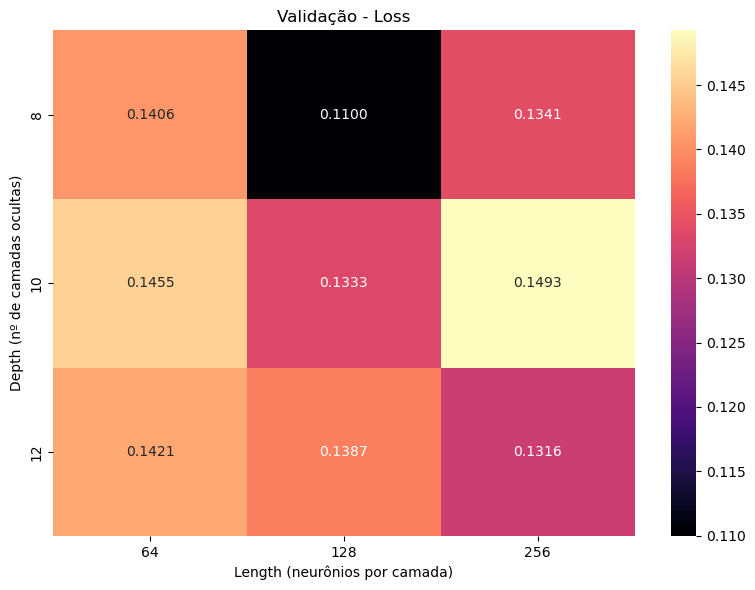

In [18]:
heatmap(accuracy_matrix, 'Length (neurônios por camada)', 'Depth (nº de camadas ocultas)', 'Validação - Acurácia', length_values, depth_values)
heatmap(val_loss_matrix, 'Length (neurônios por camada)', 'Depth (nº de camadas ocultas)', 'Validação - Loss', length_values, depth_values, cmap='magma')

Com base nos gráficos, pode-se perceber e confirmar que:
- A largura aumenta a capacidade da rede de aprender padrões complexos. Se for muito grande, pode causar overfitting, resultando em val_loss alto.
- A profundidade permite aprender representações mais complexas. No entanto, muitas camadas dificultam o treinamento e podem causar instabilidade.
- Modelos com profundidade e largura baixas tendem a underfitting.
- Modelos com profundidade e largura altas podem "decorar" os dados, causando overfitting.

Dessa forma, percebe-se que o equilíbrio entre largura e profundidade é essencial para a implementação de um bom modelo.

Para nosso caso de teste, notou-se que a melhor combinação é dada quando a largura é de 128 neurônios e a profundidade é de 8 camadas.



 #### Estudo da variação da taxa de aprendizado e o número de épocas

Com o intuito de estudar como a variação do learning rate e do número de épocas afetam o desempenho do modelo, iremos fazer o mesmo tipo de análise que fizemos no caso anterior mas dessa vez fixando a largura e a profundidade:

In [19]:
learning_rates = [0.001, 0.01, 0.1]
epochs_list = [10, 20, 30]

val_accuracy_matrix = np.zeros((len(epochs_list), len(learning_rates)))
val_loss_matrix = np.zeros((len(epochs_list), len(learning_rates)))
overfit_matrix = np.zeros((len(epochs_list), len(learning_rates)))

for i, e in enumerate(epochs_list):
    for j, lr in enumerate(learning_rates):
        model, history = neural_network(X, y, length=128, depth=6, learning_rate=lr, epochs=e)

        val_acc = history.history['val_accuracy'][-1]
        val_loss = history.history['val_loss'][-1]
        train_loss = history.history['loss'][-1]
        overfit = val_loss - train_loss

        val_accuracy_matrix[i, j] = val_acc
        val_loss_matrix[i, j] = val_loss
        overfit_matrix[i, j] = overfit

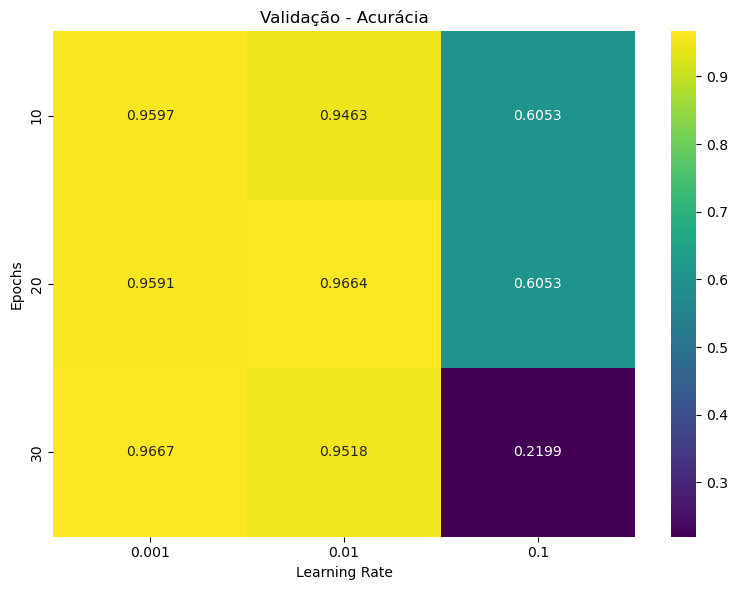

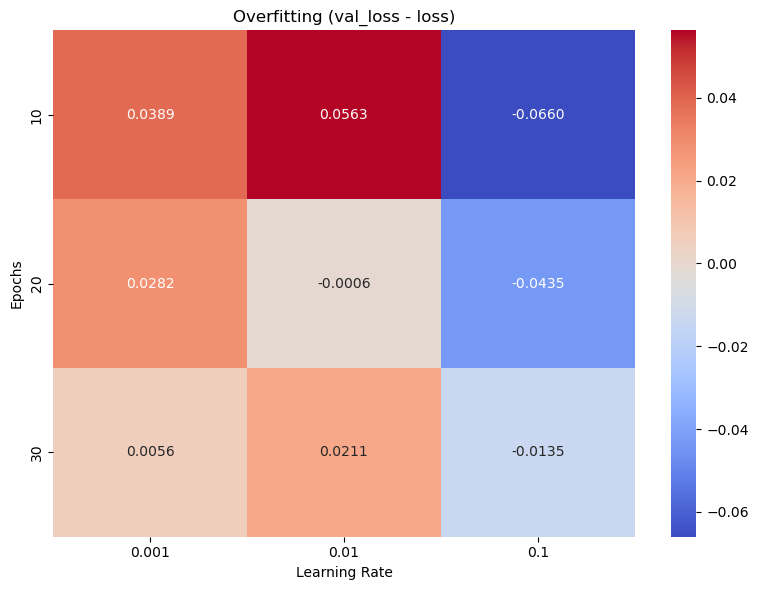

In [20]:
heatmap(val_accuracy_matrix, 'Learning Rate', 'Epochs','Validação - Acurácia', learning_rates, epochs_list)
heatmap(overfit_matrix, 'Learning Rate', 'Epochs', 'Overfitting (val_loss - loss)', learning_rates, epochs_list, cmap='coolwarm')

Com base nos gráficos obtidos, pode-se concluir e confirmar que: 
- Um learning rate alto acelera o aprendizado, mas pode fazer a rede pular padrões, resultando em val_loss instável ou alto. Um valor muito baixo torna o treino muito lento.
- Mais épocas permitem que o modelo aprenda padrões mais complexos. Em excesso causa overfitting.
- Poucas épocas podem levar a underfitting.

O ideal é encontrar a combinação ideal de learning rate e o número de épocas para atingir um ponto ótimo.

Em nosso caso, percebe-se que a melhor combinação se deu quando o learning rate era de 0,001 e o número de épocas era de 30.

 #### Estudo da regularização e otimização

Com o intuito de compreender como a regularização e a otimização afetam o desempenho do modelo, vamos implementar a mesma lógica proposta nos tópicos anteriores, mas fixando todos os parâmetros exceto os regularizators, dropouts e optimizers.

In [21]:
length = 64
depth = 6
learning_rate = 0.001
epochs = 3

# Parâmetros variáveis
regularizations = [None, 'l2', 'l1']
dropouts = [None, 0.2, 0.4]
optimizers = ['adam', 'sgd', 'rmsprop', 'adagrad']

results = []

combinations = list(product(regularizations, dropouts, optimizers))

for reg, do, opt in combinations:
    print(f"Regularização={reg}, dropout={do}, otimizador={opt}")
    
    model, history = neural_network(X, y,
                                    length=length,
                                    depth=depth,
                                    learning_rate=learning_rate,
                                    epochs=epochs,
                                    regularization=reg,
                                    dropout=do,
                                    optimizer_name=opt)
    
    best_epoch = np.argmin(history.history['val_loss'])
    val_acc = history.history['val_accuracy'][best_epoch]
    val_loss = history.history['val_loss'][best_epoch]
    train_loss = history.history['loss'][best_epoch]
    overfit = val_loss - train_loss

    results.append({
        'regularization': reg,
        'dropout': do,
        'optimizer': opt,
        'val_accuracy': val_acc,
        'val_loss': val_loss,
        'overfitting': overfit
    })

df_results = pd.DataFrame(results)

Regularização=None, dropout=None, otimizador=adam
Regularização=None, dropout=None, otimizador=sgd
Regularização=None, dropout=None, otimizador=rmsprop
Regularização=None, dropout=None, otimizador=adagrad
Regularização=None, dropout=0.2, otimizador=adam
Regularização=None, dropout=0.2, otimizador=sgd
Regularização=None, dropout=0.2, otimizador=rmsprop
Regularização=None, dropout=0.2, otimizador=adagrad
Regularização=None, dropout=0.4, otimizador=adam
Regularização=None, dropout=0.4, otimizador=sgd
Regularização=None, dropout=0.4, otimizador=rmsprop
Regularização=None, dropout=0.4, otimizador=adagrad
Regularização=l2, dropout=None, otimizador=adam
Regularização=l2, dropout=None, otimizador=sgd
Regularização=l2, dropout=None, otimizador=rmsprop
Regularização=l2, dropout=None, otimizador=adagrad
Regularização=l2, dropout=0.2, otimizador=adam
Regularização=l2, dropout=0.2, otimizador=sgd
Regularização=l2, dropout=0.2, otimizador=rmsprop
Regularização=l2, dropout=0.2, otimizador=adagrad
Reg

Vamos ordenar os resultados em ordem decrescente de acurácia:

In [22]:
df_results.sort_values(by='val_accuracy', ascending=False)

,regularization,dropout,optimizer,val_accuracy,val_loss,overfitting
14,l2,NaN,rmsprop,0.962173,0.181662,-0.026303
10,None,0.4,rmsprop,0.960947,0.170704,-0.080414
0,None,NaN,adam,0.959464,0.131441,-0.005146
4,None,0.2,adam,0.957573,0.135929,-0.030610
26,l1,NaN,rmsprop,0.957164,0.289146,-0.044909
20,l2,0.4,adam,0.956295,0.199546,-0.038163
12,l2,NaN,adam,0.955835,0.192527,0.012546
29,l1,0.2,sgd,0.955835,1.262061,-0.206408
8,None,0.4,adam,0.955733,0.144559,-0.064181
25,l1,NaN,sgd,0.955579,1.269619,-0.161114


A regularização ajuda a reduzir o overfitting, forçando a rede a aprender padrões mais gerais. Isso geralmente aumenta a acurácia e diminui o val_loss em dados de teste.

Os métodos de otimização influenciam a velocidade e estabilidade do aprendizado.

Otimizadores como o Adam costumam convergir mais rápido e lidar melhor com mínimos locais.

Conforme visto, obtivemos o melhor resultado dadas as devidas circustâncias, quando:

- Otimizador: Adam
- Dropout: None
- Regularização: L1

 #### Grid search para encontrar os melhores parâmetros

Com o intuito de encontrar a combinação que maximiza o desempenho da rede neural, podemos implementar um grid search como o do código a seguir. O código testa todas as possíveis combinações de valores escolhidos e retorna a melhor combinação.

Estaremos fixando apenas o otimizador, o dropout e a regularização, os quais estão definidos a seguir:
- Otimizador: Adam
- Dropout: None
- Regularização: None

In [26]:
depth_list = [6, 10, 12]
length_list = [64, 128, 256]
learning_rates = [0.001, 0.01]
epochs_list = [30, 40]

results = []

combinations = list(product(depth_list, length_list, learning_rates, epochs_list))
print(f"Total de combinações a testar: {len(combinations)}")

for depth, length, lr, epochs in combinations:    
    model, history = neural_network(
        X, y,
        length=length,
        depth=depth,
        learning_rate=lr,
        epochs=epochs
    )

    val_loss_list = history.history['val_loss']
    train_loss_list = history.history['loss']
    val_acc_list = history.history['val_accuracy']

    best_epoch = np.argmin(val_loss_list)

    val_loss = val_loss_list[best_epoch]
    train_loss = train_loss_list[best_epoch]
    val_acc = val_acc_list[best_epoch]
    overfit = val_loss - train_loss

    results.append({
        'depth': depth,
        'length': length,
        'learning_rate': lr,
        'epochs': epochs,
        'val_accuracy': val_acc,
        'val_loss': val_loss,
        'overfitting': overfit
    })

df_results = pd.DataFrame(results)

melhor_comb = df_results.sort_values(by='val_accuracy', ascending=False).iloc[0]

Total de combinações a testar: 36


In [27]:
print("\nMelhor combinação encontrada:")
print(melhor_comb)


Melhor combinação encontrada:
depth             12.000000
length           256.000000
learning_rate      0.001000
epochs            30.000000
val_accuracy       0.969943
val_loss           0.099587
overfitting       -0.009348
Name: 32, dtype: float64


Por meio do grid search, obtivemos os seguintes parâmetros, os quais maximizaram a performance do modelo:
- depth: 12
- lenght: 256
- learning_rate: 0,001
- epochs: 30

com base nisso, o **modelo foi capaz de predizer corretamente cerca de 97% dos dados, com um val_loss de 0,099 e um overfitting de -0,0093**.

O resultado obtido é esperado e desejado em contextos de ciência e astronomia, revelando uma boa performance do modelo implementado. 
